In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NegativeBinomialOutput

from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import TFTEstimator

In [4]:
dataset = get_dataset("taxi_30min")

In [5]:
estimator = TFTEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling=True,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
       
        distr_output=NegativeBinomialOutput(),
        
        batch_size=256,
        num_batches_per_epoch=200,
        trainer_kwargs=dict(gpus="1", max_epochs=100, logger=CSVLogger(".", "lightning_logs/")),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'train_loss' reached 2.69401 (best 2.69401), saving model to './lightning_logs/version_43/checkpoints/epoch=0-step=200.ckpt' as top 1
Epoch 1, global step 400: 'train_loss' reached 2.46968 (best 2.46968), saving model to './lightning_logs/version_43/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 2, global step 600: 'train_loss' reached 2.43729 (best 2.43729), saving model to './lightning_logs/version_43/checkpoints/epoch=2-step=600.ckpt' as top 1
Epoch 3, global step 800: 'train_loss' reached 2.41880 (best 2.41880), saving model to './lightning_logs/version_43/checkpoints/epoch=3-step=800.ckpt' as top 1
Epoch 4, global step 1000: 'train_loss' reached 2.41059 (best 2.41059), saving model to './lightning_logs/version_43/checkpoints/epoch=4-step=1000.ckpt' as top 1
Epoch 5, global step 1200: 'train_loss' reached 2.39735 (best 2.39735), saving model to './lightning_logs/version_43/checkpoints/epoch=5-step=1200.ckpt' as top 1
Epoch 6, global step 1400: 'train_lo

Epoch 78, global step 15800: 'train_loss' reached 2.33274 (best 2.33274), saving model to './lightning_logs/version_43/checkpoints/epoch=78-step=15800.ckpt' as top 1
Epoch 79, global step 16000: 'train_loss' was not in top 1
Epoch 80, global step 16200: 'train_loss' was not in top 1
Epoch 81, global step 16400: 'train_loss' was not in top 1
Epoch 82, global step 16600: 'train_loss' was not in top 1
Epoch 83, global step 16800: 'train_loss' was not in top 1
Epoch 84, global step 17000: 'train_loss' was not in top 1
Epoch 85, global step 17200: 'train_loss' was not in top 1
Epoch 86, global step 17400: 'train_loss' was not in top 1
Epoch 87, global step 17600: 'train_loss' was not in top 1
Epoch 88, global step 17800: 'train_loss' was not in top 1
Epoch 89, global step 18000: 'train_loss' was not in top 1
Epoch 90, global step 18200: 'train_loss' was not in top 1
Epoch 91, global step 18400: 'train_loss' was not in top 1
Epoch 92, global step 18600: 'train_loss' was not in top 1
Epoch 93

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 67984it [00:00, 142854.71it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [12]:
agg_metrics

{'MSE': 22.191201126986023,
 'abs_error': 4706165.0,
 'abs_target_sum': 12453360.0,
 'abs_target_mean': 7.632531183807954,
 'seasonal_error': 3.785588038176638,
 'MASE': 0.7679662683022549,
 'MAPE': 0.6227120212137879,
 'sMAPE': 0.5840053151562108,
 'MSIS': 6.27759755717319,
 'QuantileLoss[0.1]': 2030002.1999999997,
 'Coverage[0.1]': 0.09591717659057032,
 'QuantileLoss[0.2]': 3154084.4000000004,
 'Coverage[0.2]': 0.17071234898407467,
 'QuantileLoss[0.3]': 3942794.8,
 'Coverage[0.3]': 0.25098491311681176,
 'QuantileLoss[0.4]': 4454392.8,
 'Coverage[0.4]': 0.3367986094767396,
 'QuantileLoss[0.5]': 4706165.0,
 'Coverage[0.5]': 0.4278427031850631,
 'QuantileLoss[0.6]': 4687974.8,
 'Coverage[0.6]': 0.5141883874637169,
 'QuantileLoss[0.7]': 4387994.800000001,
 'Coverage[0.7]': 0.6137902545697027,
 'QuantileLoss[0.8]': 3745909.9999999995,
 'Coverage[0.8]': 0.7175101249313564,
 'QuantileLoss[0.9]': 2630104.599999999,
 'Coverage[0.9]': 0.8267594826233622,
 'RMSE': 4.710753774820546,
 'NRMSE': 0

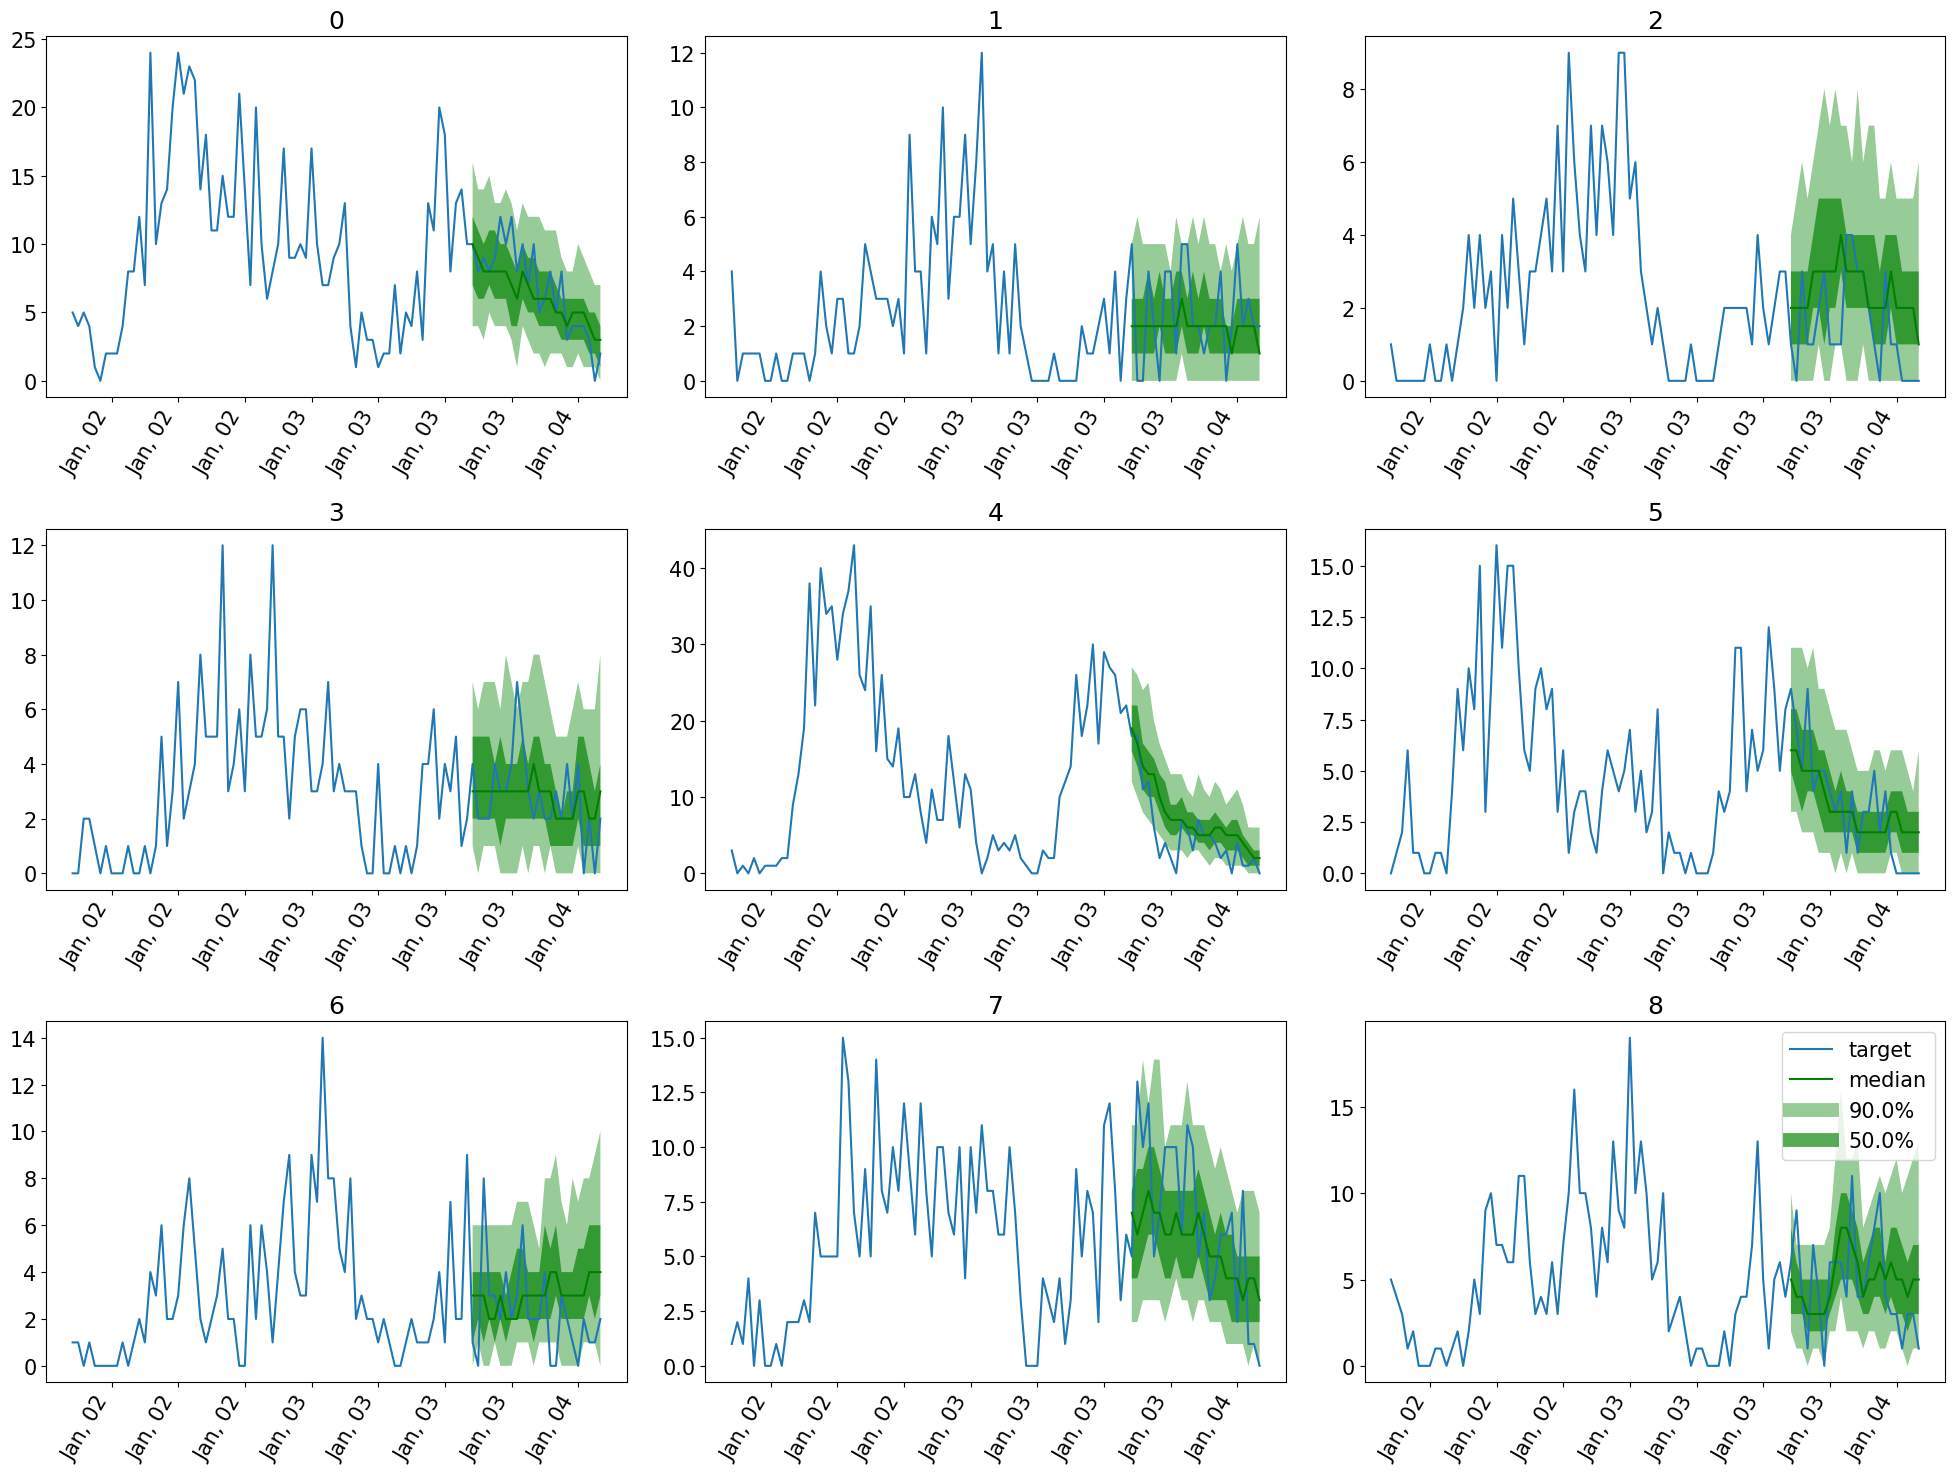

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
metrics = pd.read_csv("lightning_logs/version_86/metrics.csv")

In [19]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,2.042362,0,49,NaN,NaN
1,2.050069,0,99,NaN,NaN
2,2.743227,0,149,NaN,NaN
3,2.440984,0,199,NaN,NaN
4,NaN,0,199,4.355846,NaN
...,...,...,...,...,...
295,80.659866,49,9899,NaN,NaN
296,82.568138,49,9949,NaN,NaN
297,81.211136,49,9999,NaN,NaN
298,NaN,49,9999,1.084462,NaN


Text(0, 0.5, 'perplexity')

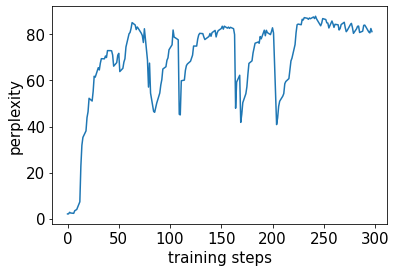

In [20]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

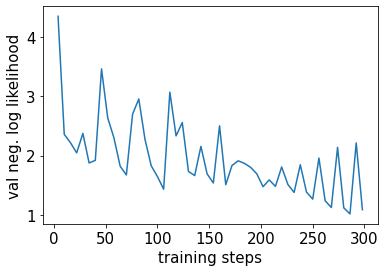

In [21]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [22]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

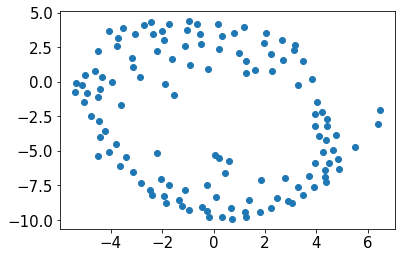

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)